In [62]:
import os
from pathlib import Path
import random
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from tqdm.auto import tqdm

import torchvision.transforms as T
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

In [31]:

COMP_PATH = Path("../input/deep-learning-for-computer-vision-and-nlp-2026-01")
FOLDS_PATH = Path("../input/petfinder-train-folds/train_folds.csv")  # зміниться під твою назву на Kaggle

TRAIN_CSV = COMP_PATH / "train.csv"
TEST_CSV  = COMP_PATH / "test.csv"
IMG_DIR_TRAIN   = COMP_PATH / "images/images/train"
IMG_DIR_TEST    = COMP_PATH / "images/images/test"
IMG_DIR = COMP_PATH / "images/images"

print("train exists:", TRAIN_CSV.exists())
print("test exists :", TEST_CSV.exists())
print("images dir  :", IMG_DIR.exists())
print("folds exists:", FOLDS_PATH.exists())

train exists: True
test exists : True
images dir  : True
folds exists: True


In [32]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)
folds_df = pd.read_csv(FOLDS_PATH)

print(train_df.shape, test_df.shape, folds_df.shape)
train_df.head()

(6431, 3) (1891, 2) (6431, 3)


,PetID,Description,AdoptionSpeed
0,d3b4f29f8,Mayleen and Flo are two lovely adorable sister...,2
1,e9dc82251,A total of 5 beautiful Tabbys available for ad...,2
2,8111f6d4a,Two-and-a-half month old girl. Very manja and ...,2
3,693a90fda,Neil is a healthy and active ~2-month-old fema...,2
4,9d08c85ef,Gray kitten available for adoption in sungai p...,2


In [33]:
train_df = train_df.merge(folds_df, on=["PetID", "AdoptionSpeed"], how="inner")
print("after merge:", train_df.shape)
train_df[["PetID","AdoptionSpeed","fold"]].head()

after merge: (6431, 4)


,PetID,AdoptionSpeed,fold
0,d3b4f29f8,2,3
1,e9dc82251,2,3
2,8111f6d4a,2,2
3,693a90fda,2,4
4,9d08c85ef,2,3


In [34]:
train_imgs = list(IMG_DIR_TRAIN.glob("*"))
print("total image files:", len(train_imgs))
print("sample:", [p.name for p in train_imgs[:10]])

total image files: 28472
sample: ['61d4dc56b-12.jpg', '53923463d-9.jpg', '0173c456c-8.jpg', 'fa7c7d1be-3.jpg', '1a030d758-1.jpg', 'd9f692e74-2.jpg', 'ebc345fe0-4.jpg', '2c24655fe-6.jpg', '94438a5c5-4.jpg', 'c9ff29578-13.jpg']


In [35]:
# Check matching between image files and CSV PetIDs

petids_in_csv = set(train_df["PetID"].astype(str))

sample_files = random.sample(train_imgs, 200)
prefixes = [p.name.split("-", 1)[0] for p in sample_files]

match_rate = sum(pref in petids_in_csv for pref in prefixes) / len(prefixes)

print("Match rate:", match_rate)
print("Example prefixes:", prefixes[:10])

Match rate: 1.0
Example prefixes: ['dbcf45977', '0bf9dfa21', '00af25fc0', 'faf13c5cd', '8f38dbd18', '6f863a03a', '44594e996', '082a9b790', '7e250a5f1', '8d39ce00b']


In [36]:
petid_to_images = defaultdict(list)

for img_path in train_imgs:
    pet_id = img_path.name.split("-", 1)[0]
    petid_to_images[pet_id].append(img_path)

print("Total PetIDs with images:", len(petid_to_images))

Total PetIDs with images: 6431


In [37]:
test_imgs = list(IMG_DIR_TEST.glob("*"))
print("total image files:", len(test_imgs))
print("sample:", [p.name for p in test_imgs[:10]])

total image files: 9448
sample: ['cf8d949f9-2.jpg', '41e824cbe-3.jpg', '687be6419-4.jpg', '081199ea2-12.jpg', '924cc5438-4.jpg', 'b1ed265ef-11.jpg', '9daaa4e8f-1.jpg', '062de1f53-4.jpg', '0ce5d0b5f-3.jpg', 'd4bb8cf0a-4.jpg']


In [38]:
petids_in_csv = set(test_df["PetID"].astype(str))

sample_files = random.sample(test_imgs, 200)
prefixes = [p.name.split("-", 1)[0] for p in sample_files]

match_rate = sum(pref in petids_in_csv for pref in prefixes) / len(prefixes)

print("Match rate:", match_rate)
print("Example prefixes:", prefixes[:10])

Match rate: 0.985
Example prefixes: ['c80811400', '028d42a4b', '063e2d021', '8ca64b428', '6da65afb8', 'ab3759aae', '1108027ef', '307b61689', '576f4893f', '227b372a2']


In [39]:
petid_to_images_test = defaultdict(list)

for img_path in test_imgs:
    pet_id = img_path.name.split("-", 1)[0]
    petid_to_images_test[pet_id].append(img_path)

print("Total PetIDs with images:", len(petid_to_images_test))
print("Total PetIDs with images:", len(petid_to_images))

Total PetIDs with images: 1899
Total PetIDs with images: 6431


In [40]:
available_test_petids = set(petid_to_images_test.keys())

before = len(test_df)
test_df = test_df[test_df["PetID"].isin(available_test_petids)].reset_index(drop=True)
after = len(test_df)

print(f"Filtered test_df: {before} -> {after}")

Filtered test_df: 1891 -> 1887


In [41]:
# example output
some_pet = list(petid_to_images.keys())[3]
print(some_pet)
print(petid_to_images[some_pet])

fa7c7d1be
[PosixPath('../input/deep-learning-for-computer-vision-and-nlp-2026-01/images/images/train/fa7c7d1be-3.jpg'), PosixPath('../input/deep-learning-for-computer-vision-and-nlp-2026-01/images/images/train/fa7c7d1be-1.jpg'), PosixPath('../input/deep-learning-for-computer-vision-and-nlp-2026-01/images/images/train/fa7c7d1be-2.jpg'), PosixPath('../input/deep-learning-for-computer-vision-and-nlp-2026-01/images/images/train/fa7c7d1be-4.jpg')]


In [42]:
class PetDataset(Dataset):
    def __init__(self, df, petid_to_images, transform=None):
        self.df = df.reset_index(drop=True)
        self.petid_to_images = petid_to_images
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pet_id = row["PetID"]
        label = row["AdoptionSpeed"] - 1  # make labels 0-based

        img_path = random.choice(self.petid_to_images[pet_id])  # baseline: randomly choose one image
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

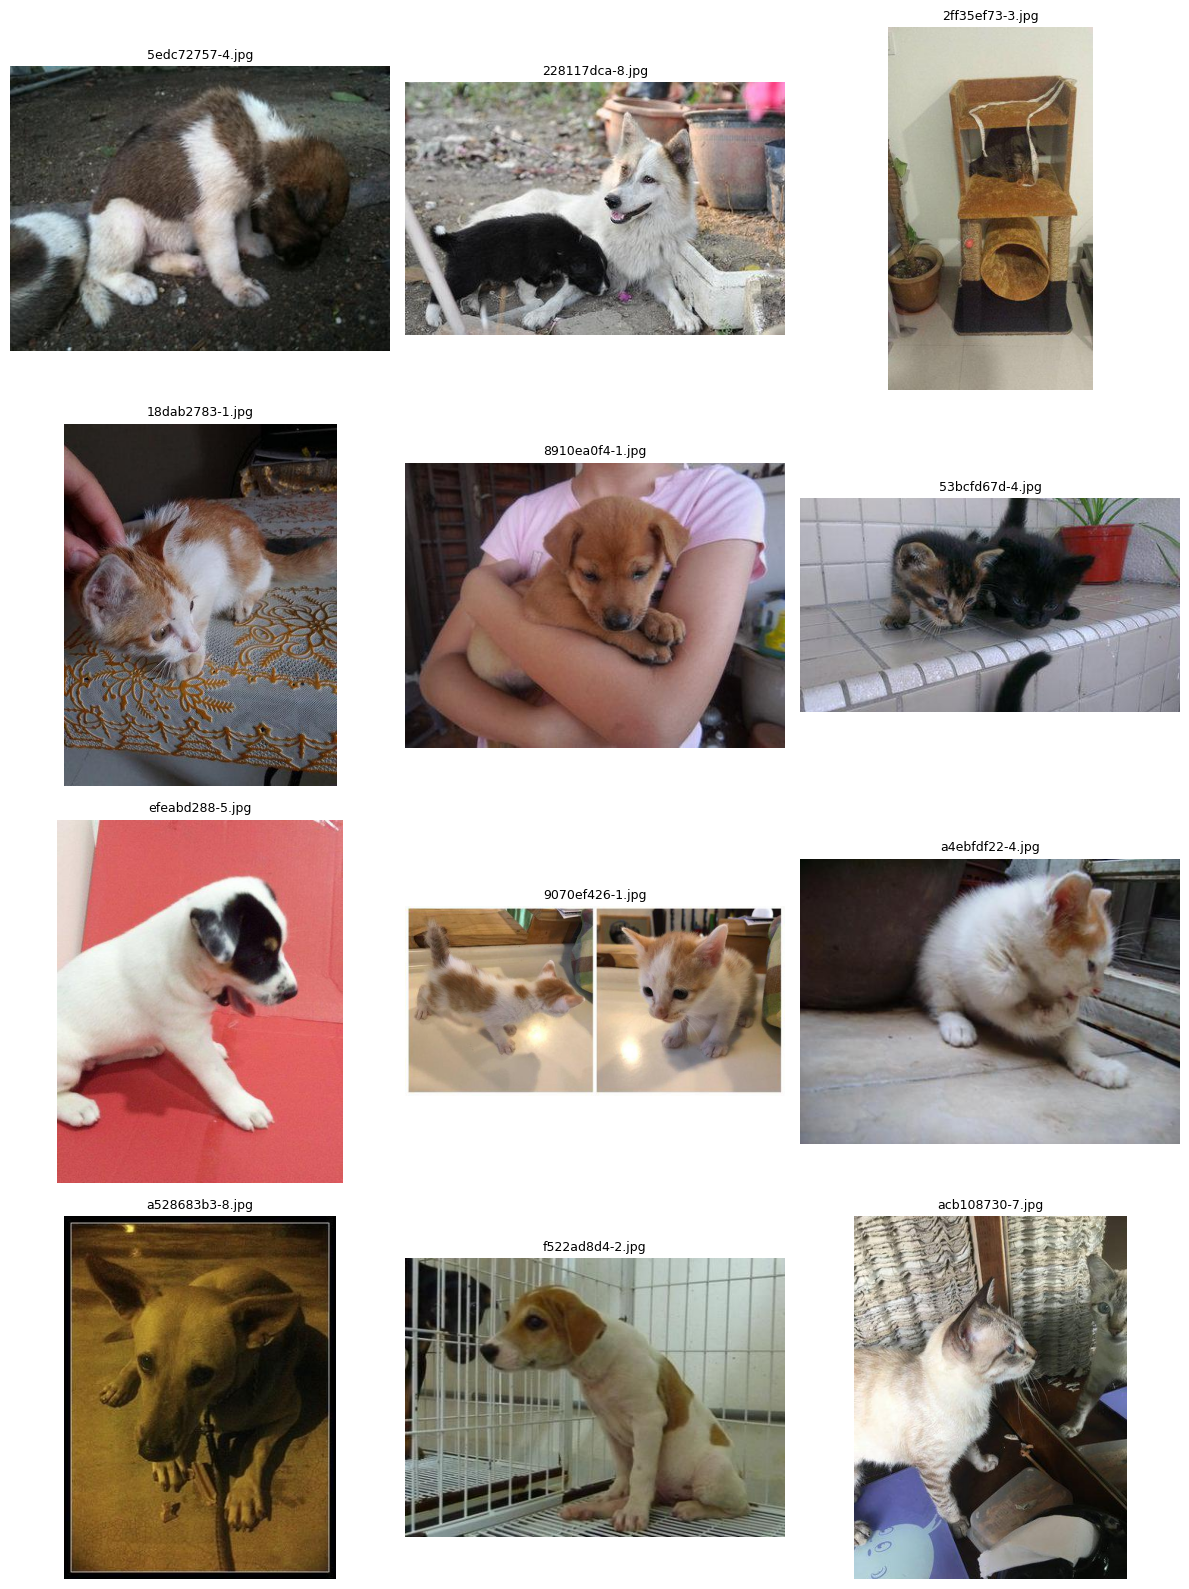

In [43]:
n_rows, n_cols = 4, 3
n = n_rows * n_cols

sample_paths = random.sample(train_imgs, k=n)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 16))
axes = axes.flatten()

for ax, p in zip(axes, sample_paths):
    img = Image.open(p).convert("RGB")
    ax.imshow(img)
    ax.set_title(p.name, fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [44]:
IMG_SIZE = 224

weights = EfficientNet_B0_Weights.DEFAULT
mean = weights.transforms().mean
std  = weights.transforms().std

train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

val_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

In [45]:
FOLD = 0

df_tr = train_df[train_df["fold"] != FOLD].reset_index(drop=True)
df_va = train_df[train_df["fold"] == FOLD].reset_index(drop=True)

train_ds = PetDataset(df_tr, petid_to_images, transform=train_tfms)
val_ds   = PetDataset(df_va, petid_to_images, transform=val_tfms)

len(train_ds), len(val_ds)

(5144, 1287)

In [46]:
BATCH_SIZE = 32
NUM_WORKERS = 0 
N_SPLITS = 5
EPOCHS = 6
LR = 1e-3     
PIN_MEMORY  = False

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,     
    drop_last=True       
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    drop_last=False
)

print("train batches:", len(train_loader))
print("val batches  :", len(val_loader))

train batches: 160
val batches  : 41


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [48]:
NUM_CLASSES = 4

def build_model(num_classes=NUM_CLASSES):
    weights = EfficientNet_B0_Weights.DEFAULT
    model = efficientnet_b0(weights=weights)

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

In [49]:
model = build_model()

# Перевіряємо архітектуру
print(model.classifier) 
# Має вивести щось типу:
# Sequential(
#   (0): Dropout(p=0.2, inplace=True)
#   (1): Linear(in_features=1280, out_features=4, bias=True)  <-- ТУТ МАЄ БУТИ 4!
# )

# Перевіряємо на фейкових даних
dummy_input = torch.randn(2, 3, 224, 224) # 2 картинки, 3 канали, 224x224
output = model(dummy_input)
print("Output shape:", output.shape) 

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)
Output shape: torch.Size([2, 4])


In [50]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()  # режим навчання (вмикає dropout, batchnorm у train-режимі)

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="train", leave=False)

    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()          # обнуляємо градієнти
        logits = model(x)              # прямий прохід
        loss = criterion(logits, y)    # рахуємо loss

        loss.backward()                # зворотний прохід (градієнти)
        optimizer.step()               # крок оптимізатора

        bs = x.size(0)
        running_loss += loss.item() * bs
        total += bs

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()

        pbar.set_postfix(loss=float(loss.item()))

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [51]:
@torch.no_grad()
def valid_epoch_with_probs(model, loader, criterion, device):
    model.eval()  # режим оцінки (вимикає dropout тощо)

    running_loss = 0.0
    correct = 0
    total = 0

    probs_list = []

    pbar = tqdm(loader, desc="valid", leave=False)

    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        running_loss += loss.item() * bs
        total += bs

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()

        probs = F.softmax(logits, dim=1).detach().cpu().numpy()  # (bs, 4)
        probs_list.append(probs)

        pbar.set_postfix(loss=float(loss.item()))

    val_loss = running_loss / total
    val_acc = correct / total
    val_probs = np.vstack(probs_list)  # (N_val, 4)

    return val_loss, val_acc, val_probs


In [52]:
missing_train = sum(pid not in petid_to_images for pid in train_df["PetID"].values)
missing_test  = sum(pid not in petid_to_images_test for pid in test_df["PetID"].values)

print("missing train petids:", missing_train)
print("missing test  petids:", missing_test)

missing train petids: 0
missing test  petids: 0


In [53]:
criterion = nn.CrossEntropyLoss()

In [54]:
ARTIFACTS_DIR = Path("/kaggle/working/artifacts")
WEIGHTS_DIR   = ARTIFACTS_DIR / "weights"

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)

print("ARTIFACTS_DIR:", ARTIFACTS_DIR)
print("WEIGHTS_DIR  :", WEIGHTS_DIR)

ARTIFACTS_DIR: /kaggle/working/artifacts
WEIGHTS_DIR  : /kaggle/working/artifacts/weights


In [55]:
class PetTestDataset(Dataset):
    def __init__(self, df, petid_to_images_test, transform=None):
        self.df = df.reset_index(drop=True)
        self.petid_to_images = petid_to_images_test
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pet_id = str(self.df.iloc[idx]["PetID"])
        img_path = random.choice(self.petid_to_images[pet_id])  # беремо випадкове фото цього PetID
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, pet_id

In [56]:
@torch.no_grad()
def predict_test_probs(model, loader, device):
    model.eval()
    probs_list = []
    petids = []

    for x, pid in tqdm(loader, desc="test", leave=False):
        x = x.to(device)
        logits = model(x)
        probs = F.softmax(logits, dim=1).detach().cpu().numpy()
        probs_list.append(probs)
        petids.extend(list(pid))

    return np.array(petids), np.vstack(probs_list)

In [57]:
test_ds = PetTestDataset(test_df, petid_to_images_test, transform=val_tfms)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=False,
    drop_last=False
)

In [60]:
oof_probs = np.zeros((len(train_df), NUM_CLASSES), dtype=np.float32)
test_probs_accum = np.zeros((len(test_df), NUM_CLASSES), dtype=np.float32)

for fold in range(N_SPLITS):
    print(f"\n===== FOLD {fold} / {N_SPLITS - 1} =====")

    # 1) split
    df_tr = train_df[train_df["fold"] != fold].reset_index(drop=True)
    df_va = train_df[train_df["fold"] == fold].reset_index(drop=True)

    # 2) datasets
    train_ds = PetDataset(df_tr, petid_to_images, transform=train_tfms)
    val_ds   = PetDataset(df_va, petid_to_images, transform=val_tfms)

    # 3) loaders (per fold, бо split змінюється)
    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=False,
        drop_last=True
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=False,
        drop_last=False
    )

    # 4) model + optimizer
    model = build_model(NUM_CLASSES).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    # 5) train epochs
    for epoch in range(EPOCHS):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        va_loss, va_acc, _ = valid_epoch_with_probs(model, val_loader, criterion, device)
        print(
            f"epoch {epoch+1}/{EPOCHS} | "
            f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
            f"val loss {va_loss:.4f} acc {va_acc:.4f}"
        )

    # 6) final val probs (OOF)
    va_loss, va_acc, fold_probs = valid_epoch_with_probs(model, val_loader, criterion, device)
    print(f"FOLD {fold} FINAL | val loss {va_loss:.4f} acc {va_acc:.4f}")

    val_index = train_df.index[train_df["fold"] == fold].to_numpy()
    oof_probs[val_index] = fold_probs

    # 7) save weights
    wpath = WEIGHTS_DIR / f"effnetb0_fold{fold}.pth"
    torch.save(model.state_dict(), wpath)
    print("saved weights:", wpath)

    # 8) test inference for this fold (ensemble)
    _, fold_test_probs = predict_test_probs(model, test_loader, device)
    test_probs_accum += fold_test_probs / N_SPLITS

    # 9) cleanup
    del model, optimizer, train_loader, val_loader, train_ds, val_ds
    gc.collect()
    torch.cuda.empty_cache()


===== FOLD 0 / 4 =====


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 1/6 | train loss 1.3255 acc 0.3758 | val loss 1.3379 acc 0.3730


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 2/6 | train loss 1.2895 acc 0.4021 | val loss 1.2676 acc 0.4312


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 3/6 | train loss 1.2530 acc 0.4387 | val loss 1.2818 acc 0.4289


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 4/6 | train loss 1.2268 acc 0.4500 | val loss 1.2732 acc 0.4141


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 5/6 | train loss 1.2127 acc 0.4619 | val loss 1.2699 acc 0.4235


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 6/6 | train loss 1.1951 acc 0.4646 | val loss 1.2791 acc 0.4219


valid:   0%|          | 0/41 [00:00<?, ?it/s]

FOLD 0 FINAL | val loss 1.2676 acc 0.4351
saved weights: /kaggle/working/artifacts/weights/effnetb0_fold0.pth


test:   0%|          | 0/59 [00:00<?, ?it/s]


===== FOLD 1 / 4 =====


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 1/6 | train loss 1.3138 acc 0.3969 | val loss 1.3112 acc 0.3950


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 2/6 | train loss 1.2714 acc 0.4131 | val loss 1.2956 acc 0.4145


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 3/6 | train loss 1.2523 acc 0.4387 | val loss 1.2579 acc 0.4238


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 4/6 | train loss 1.2192 acc 0.4494 | val loss 1.2759 acc 0.4308


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 5/6 | train loss 1.2078 acc 0.4625 | val loss 1.2763 acc 0.4184


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 6/6 | train loss 1.1857 acc 0.4764 | val loss 1.2445 acc 0.4619


valid:   0%|          | 0/41 [00:00<?, ?it/s]

FOLD 1 FINAL | val loss 1.2368 acc 0.4487
saved weights: /kaggle/working/artifacts/weights/effnetb0_fold1.pth


test:   0%|          | 0/59 [00:00<?, ?it/s]


===== FOLD 2 / 4 =====


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 1/6 | train loss 1.3234 acc 0.3768 | val loss 1.3122 acc 0.3849


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 2/6 | train loss 1.2898 acc 0.4096 | val loss 1.2880 acc 0.4020


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 3/6 | train loss 1.2588 acc 0.4326 | val loss 1.2952 acc 0.4067


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 4/6 | train loss 1.2373 acc 0.4441 | val loss 1.3249 acc 0.4152


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 5/6 | train loss 1.2109 acc 0.4570 | val loss 1.2935 acc 0.4487


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 6/6 | train loss 1.1990 acc 0.4709 | val loss 1.3025 acc 0.4253


valid:   0%|          | 0/41 [00:00<?, ?it/s]

FOLD 2 FINAL | val loss 1.3051 acc 0.4316
saved weights: /kaggle/working/artifacts/weights/effnetb0_fold2.pth


test:   0%|          | 0/59 [00:00<?, ?it/s]


===== FOLD 3 / 4 =====


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 1/6 | train loss 1.3267 acc 0.3807 | val loss 1.3133 acc 0.4121


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 2/6 | train loss 1.2847 acc 0.4139 | val loss 1.2971 acc 0.3872


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 3/6 | train loss 1.2467 acc 0.4393 | val loss 1.2813 acc 0.4207


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 4/6 | train loss 1.2362 acc 0.4434 | val loss 1.2707 acc 0.4199


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 5/6 | train loss 1.2015 acc 0.4682 | val loss 1.2999 acc 0.4152


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 6/6 | train loss 1.1833 acc 0.4721 | val loss 1.3225 acc 0.4238


valid:   0%|          | 0/41 [00:00<?, ?it/s]

FOLD 3 FINAL | val loss 1.3107 acc 0.4152
saved weights: /kaggle/working/artifacts/weights/effnetb0_fold3.pth


test:   0%|          | 0/59 [00:00<?, ?it/s]


===== FOLD 4 / 4 =====


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 1/6 | train loss 1.3202 acc 0.3846 | val loss 1.3029 acc 0.3911


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 2/6 | train loss 1.2790 acc 0.4201 | val loss 1.2871 acc 0.4020


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 3/6 | train loss 1.2572 acc 0.4264 | val loss 1.2831 acc 0.4253


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 4/6 | train loss 1.2326 acc 0.4383 | val loss 1.2553 acc 0.4316


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 5/6 | train loss 1.2059 acc 0.4568 | val loss 1.3039 acc 0.4129


train:   0%|          | 0/160 [00:00<?, ?it/s]

valid:   0%|          | 0/41 [00:00<?, ?it/s]

epoch 6/6 | train loss 1.1887 acc 0.4775 | val loss 1.2800 acc 0.4253


valid:   0%|          | 0/41 [00:00<?, ?it/s]

FOLD 4 FINAL | val loss 1.2965 acc 0.4230
saved weights: /kaggle/working/artifacts/weights/effnetb0_fold4.pth


test:   0%|          | 0/59 [00:00<?, ?it/s]

In [63]:
y_true = (train_df["AdoptionSpeed"].values - 1).astype(int)  # 0..3

# найпростіше: клас = argmax по ймовірностям
y_pred = oof_probs.argmax(axis=1).astype(int)

qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
print("OOF QWK:", qwk)

OOF QWK: 0.34798677825960034


In [64]:
oof_out = pd.DataFrame({"PetID": train_df["PetID"].values, "fold": train_df["fold"].values})
for c in range(NUM_CLASSES):
    oof_out[f"pred_{c}"] = oof_probs[:, c]
oof_out.to_csv(ARTIFACTS_DIR / "cnn_oof.csv", index=False)

test_out = pd.DataFrame({"PetID": test_df["PetID"].values})
for c in range(NUM_CLASSES):
    test_out[f"pred_{c}"] = test_probs_accum[:, c]
test_out.to_csv(ARTIFACTS_DIR / "cnn_test.csv", index=False)

print("saved:", ARTIFACTS_DIR / "cnn_oof.csv")
print("saved:", ARTIFACTS_DIR / "cnn_test.csv")


saved: /kaggle/working/artifacts/cnn_oof.csv
saved: /kaggle/working/artifacts/cnn_test.csv


In [65]:
!zip -r /kaggle/working/artifacts_backup.zip /kaggle/working/artifacts


  adding: kaggle/working/artifacts/ (stored 0%)
  adding: kaggle/working/artifacts/cnn_oof.csv (deflated 53%)
  adding: kaggle/working/artifacts/weights/ (stored 0%)
  adding: kaggle/working/artifacts/weights/effnetb0_fold1.pth (deflated 8%)
  adding: kaggle/working/artifacts/weights/effnetb0_fold2.pth (deflated 8%)
  adding: kaggle/working/artifacts/weights/effnetb0_fold0.pth (deflated 8%)
  adding: kaggle/working/artifacts/weights/effnetb0_fold3.pth (deflated 8%)
  adding: kaggle/working/artifacts/weights/effnetb0_fold4.pth (deflated 8%)
  adding: kaggle/working/artifacts/cnn_test.csv (deflated 52%)
